This notebook contains basic info about the best architecture that was found

In [ ]:
from urllib.request import urlopen
from PIL import Image
import timm
from transforms import transforming, Transforms, get_transforms
from train import FrozenNet
import torchinfo
from utils import visualize_transformed_images, calculate_class_accuracies
from collections import defaultdict
from deployment import get_class_labels, load_model
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import warnings

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('efficientnet_b5.sw_in12k', pretrained = True, num_classes = 0)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training = False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings("ignore", message = "Palette images with Transparency expressed in bytes should be converted to RGBA images")

data_config

{'input_size': (3, 416, 416),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.95,
 'crop_mode': 'center'}

In [2]:
transforms

Compose(
    Resize(size=437, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(416, 416))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [3]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

In [4]:
model = FrozenNet()

torchinfo.summary(model, input_size = (1, 3, 416, 416))

Layer (type:depth-idx)                             Output Shape              Param #
FrozenNet                                          [1, 47]                   --
├─EfficientNet: 1-1                                [1, 2048]                 --
│    └─Conv2d: 2-1                                 [1, 48, 208, 208]         (1,296)
│    └─BatchNormAct2d: 2-2                         [1, 48, 208, 208]         96
│    │    └─Identity: 3-1                          [1, 48, 208, 208]         --
│    │    └─SiLU: 3-2                              [1, 48, 208, 208]         --
│    └─Sequential: 2-3                             [1, 512, 13, 13]          --
│    │    └─Sequential: 3-3                        [1, 24, 208, 208]         (5,352)
│    │    └─Sequential: 3-4                        [1, 40, 104, 104]         (122,846)
│    │    └─Sequential: 3-5                        [1, 64, 52, 52]           (329,514)
│    │    └─Sequential: 3-6                        [1, 128, 26, 26]          (1,632,464)
│ 

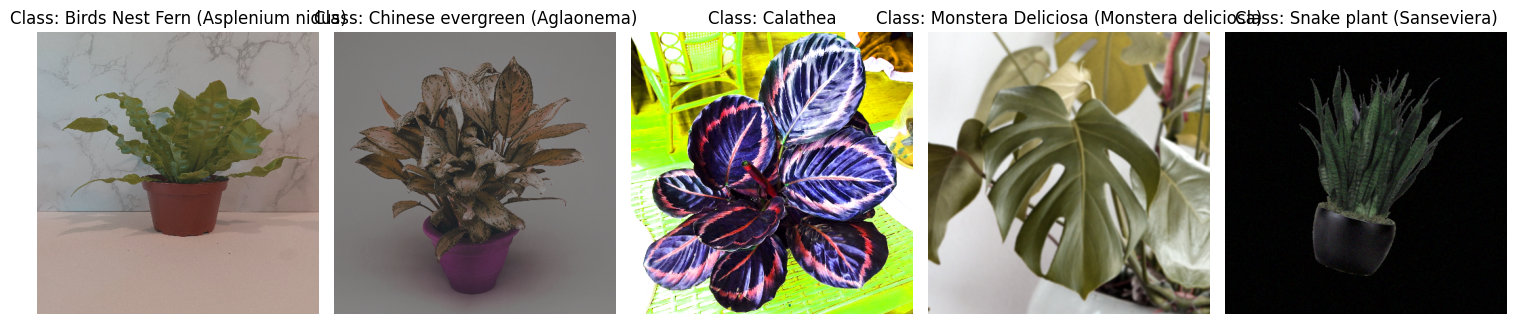

In [5]:
# Aplica transformaciones a los datos
train_data, val_data = transforming(
    selected_transforms=[ "color_jitter", "horizontal_flip", "brightness_contrast", "noise", "blur", "random_rotate"],
    resize_size = 416,
    normalize = False,
    use_float = True,
)

# Visualiza las imágenes transformadas
visualize_transformed_images(train_data, num_images = 5)


In [ ]:
# Uso de la función
if __name__ == "__main__":
    # Cargar datos de validación
    val_data = datasets.ImageFolder("house_plant_species/validation", transform = Transforms(get_transforms([])))
    val_loader = DataLoader(val_data, batch_size = 32, shuffle = False, num_workers = 6)

    # Cargar etiquetas de clases
    class_labels = get_class_labels("house_plant_species/validation")

    # Cargar el modelo desde un checkpoint
    model = load_model(
        use_checkpoint=True,
        model_name = "efficientnet_b5.sw_in12k",
        checkpoint_path = "checkpoint_epoch_9.pth",
        num_classes = len(class_labels),
        in_channels = 3
    )

    # Calcular las accuracies por clase
    class_accuracies = calculate_class_accuracies(model, val_loader, class_labels, device = device)

    # Mostrar resultados
    for class_name, accuracy in sorted(class_accuracies.items(), key=lambda x: x[1]):
        print(f"Clase: {class_name}, Accuracy: {accuracy:.2%}")


/home/josei/workspace/RN/Tarea03_Deep_Learning/deployment.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location

Modelo cargado desde checkpoint: checkpoint_epoch_9.pth


/home/josei/workspace/RN/RNENV/lib64/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/josei/workspace/RN/RNENV/lib64/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Clase: Calathea, Accuracy: 58.33%
Clase: Kalanchoe, Accuracy: 59.09%
Clase: Begonia (Begonia spp.), Accuracy: 68.29%
Clase: Areca Palm (Dypsis lutescens), Accuracy: 73.68%
Clase: Prayer Plant (Maranta leuconeura), Accuracy: 73.75%
Clase: Dracaena, Accuracy: 75.61%
Clase: Yucca, Accuracy: 76.92%
Clase: Chinese evergreen (Aglaonema), Accuracy: 78.64%
Clase: Christmas Cactus (Schlumbergera bridgesii), Accuracy: 80.95%
Clase: Parlor Palm (Chamaedorea elegans), Accuracy: 81.82%
Clase: Boston Fern (Nephrolepis exaltata), Accuracy: 81.97%
Clase: Money Tree (Pachira aquatica), Accuracy: 84.72%
Clase: Monstera Deliciosa (Monstera deliciosa), Accuracy: 85.48%
Clase: Schefflera, Accuracy: 86.21%
Clase: Elephant Ear (Alocasia spp.), Accuracy: 86.57%
Clase: Cast Iron Plant (Aspidistra elatior), Accuracy: 87.04%
Clase: Pothos (Ivy arum), Accuracy: 87.50%
Clase: Birds Nest Fern (Asplenium nidus), Accuracy: 87.93%
Clase: Ctenanthe, Accuracy: 88.64%
Clase: Peace lily, Accuracy: 89.61%
Clase: Ponytail P